In [7]:
from astropy import coordinates as coord
from astropy import io
from astropy import units as u
from astropy.table import Table
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import binned_statistic_2d as bs2d
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity as kde
from Deproject_v1 import *
from fast_kde import fast_kde
import matplotlib.pyplot as plt
import os
import numpy as np

plt.style.use('classic')

In [32]:
del data_raw

In [33]:
def calc_p_rhat(sample):

#Oort constant values from Bovy (2018)
    A = (15.3*(u.km/(u.s*u.kpc))).to(1/u.yr)
    B = (-11.9*(u.km/(u.s*u.kpc))).to(1/u.yr)

    bvals = sample.b.to(u.deg)
    lvals = sample.l.to(u.deg)

    mul_obs = sample.pm_l_cosb.to(1/u.yr,equivalencies = u.dimensionless_angles())
    mub_obs = sample.pm_b.to(1/u.yr,equivalencies = u.dimensionless_angles())

    """Computation of the relevant quantities

        l,b: Galactic coordinates
        s: the distance obtained by inverting the parallax
        mul, mub: proper motion in l and b
        pvals: Tangential velocities obtained from eq. 2 in DB98
        rhatvals: The unit vector of each star
        vmin: Vector containing the minimum velocities in v-space
        n: The number of cells we want in each dimension of our v-space box
        dv: Step sizes for each dimension"""

    b = np.deg2rad(bvals).value
    l = np.deg2rad(lvals).value
    cosl = np.cos(l)
    cosb = np.cos(b)
    sinl = np.sin(l)
    sinb = np.sin(b)
    s = sample.distance

    mul = mul_obs - A*np.cos(2*l)-B
    mub = mub_obs + A*np.sin(2*l)*cosb*sinb

    pvals = s*np.array([-sinl*cosb*mul - cosl*sinb*mub,
                     cosl*cosb*mul - sinl*sinb*mub,
                     cosb*mub])/u.yr

    rhatvals = np.array([cosb*cosl, cosb*sinl, sinb]).T
    pvals = pvals.to(u.km/u.s).value.T
    
    return pvals, rhatvals 

In [34]:
#Initiation of data, now loading GRD1 data and setting up the various parameters used in the code below

os.chdir("/home/jooehn/Documents/Summer project/GDR2 data")

try:
    data_raw
except NameError:
    data_raw = Table.read('gaiadr2_200pc_clean.fits')

# data_raw = io.fits.open('gaiadr2_20pc.fits')
    
#Physical properties

try:
    RA = data_raw['ra']
    DEC = data_raw['dec']
    pm_RA = data_raw['pmra']
    pm_DEC = data_raw['pmdec']
    parallax_raw = data_raw['parallax'].to(u.mas)

    G_mean_raw = data_raw['phot_g_mean_mag'].to(u.mag)
    BP_RP_raw = data_raw['bp_rp'].to(u.mag)
    E_BP_RP = data_raw['e_bp_min_rp_val']
    phot_bp_mean_mag = data_raw['phot_bp_mean_mag']
    phot_rp_mean_mag = data_raw['phot_rp_mean_mag']
    
except KeyError:    
    RA = data_raw['RA']*u.deg
    DEC = data_raw['DEC']*u.deg
    pm_RA = data_raw['PMRA']*u.mas/u.yr
    pm_DEC = data_raw['PMDEC']*u.mas/u.yr
    parallax_raw = data_raw['PARALLAX']*u.mas

    G_mean_raw = data_raw['PHOT_G_MEAN_MAG']*u.mag
    BP_RP_raw = data_raw['BP_RP']*u.mag
    E_BP_RP = data_raw['E_BP_MIN_RP_VAL']
    phot_bp_mean_mag = data_raw['PHOT_BP_MEAN_MAG']
    phot_rp_mean_mag = data_raw['PHOT_RP_MEAN_MAG']
    pass

parallax_raw = parallax_raw.to(u.mas) #This is done to avoid having to deal with inconsitencies in units of the datasets
G_mean_raw = G_mean_raw.to(u.mag)
BP_RP_raw = BP_RP_raw.to(u.mag)

                  
dist = parallax_raw.to(u.kpc,equivalencies=u.parallax())

sample_raw = coord.ICRS(ra = RA, dec = DEC, pm_ra_cosdec = pm_RA, pm_dec = pm_DEC,distance=dist)

sample_gc = sample_raw.transform_to(coord.Galactic)

We not have our chosen set of data in Galactic coordinates $(l,b)$ and proceed to apply cuts to the data set in order to remove data points that carry high uncertainties.

We apply the following standard cuts which are provided in the [Observational HRD paper](https://ui.adsabs.harvard.edu/#abs/2018arXiv180409378G/abstract) of Gaia Collaboration et al (2018).

\begin{align}
&\texttt{parallax_over_error} > 10 \\
&\texttt{phot_g_mean_flux_over_error} > 50 \\
&\texttt{phot_rp_mean_flux_over_error} >20 \\
&\texttt{phot_bp_mean_flux_over_error} > 20 \\
&\texttt{phot_bp_rp_excess_factor} < 1.3+0.06*(\texttt{phot_bp_mean_mag}-\texttt{phot_rp_mean_mag})^2 \\
&\texttt{phot_bp_rp_excess_factor} > 1.0+0.015*(\texttt{phot_bp_mean_mag}-\texttt{phot_rp_mean_mag})^2 \\
&\texttt{visibility_periods_used} > 8 \\
&\texttt{astrometric_chi2_al}/(\texttt{astrometric_n_good_obs_al} -5 ) < 1.44*\texttt{max}(1,\exp(-0.4*\texttt{phot_g_mean_mag}-19.5)
\end{align}

These are all given in the variable $\texttt{standard_cuts}$ and if additional cuts are desired, they can be provided in $\texttt{additional_cuts}$.

In [43]:
#Data selection
try:
    parallax_over_error = data_raw['parallax_over_error']
    phot_g_mean_flux_over_error = data_raw['phot_g_mean_flux_over_error']
    phot_rp_mean_flux_over_error = data_raw['phot_rp_mean_flux_over_error']
    phot_bp_mean_flux_over_error = data_raw['phot_bp_mean_flux_over_error']
    phot_bp_rp_excess_factor = data_raw['phot_bp_rp_excess_factor']
    visibility_periods_used = data_raw['visibility_periods_used']
    astrometric_chi2_al = data_raw['astrometric_chi2_al']
    astrometric_n_good_obs_al = data_raw['astrometric_n_good_obs_al']
except KeyError:
    parallax_over_error = data_raw['PARALLAX_OVER_ERROR']
    phot_g_mean_flux_over_error = data_raw['PHOT_G_MEAN_FLUX_OVER_ERROR']
    phot_rp_mean_flux_over_error = data_raw['PHOT_RP_MEAN_FLUX_OVER_ERROR']
    phot_bp_mean_flux_over_error = data_raw['PHOT_BP_MEAN_FLUX_OVER_ERROR']
    phot_bp_rp_excess_factor = data_raw['PHOT_BP_RP_EXCESS_FACTOR']
    visibility_periods_used = data_raw['VISIBILITY_PERIODS_USED']
    astrometric_chi2_al = data_raw['ASTROMETRIC_CHI2_AL']
    astrometric_n_good_obs_al = data_raw['ASTROMETRIC_N_GOOD_OBS_AL']

distance_cut = 1*u.kpc

chinu = np.dstack((np.exp(-0.4*(G_mean_raw.value-19.5)), np.ones((G_mean_raw.shape))))

"""Next we perform the standard cuts which are provided in Appendix B of the Observational HR-Diagram paper of
    Gaia Collaboration et al (2018)"""

standard_cuts = [parallax_over_error<10,visibility_periods_used<8,phot_g_mean_flux_over_error<50,\
           phot_rp_mean_flux_over_error<20,phot_bp_mean_flux_over_error<20,\
           phot_bp_rp_excess_factor > 1.3+0.06*(phot_bp_mean_mag-phot_rp_mean_mag)**2,\
           phot_bp_rp_excess_factor < 1.0+0.015*(phot_bp_mean_mag-phot_rp_mean_mag)**2,\
           astrometric_chi2_al/(astrometric_n_good_obs_al-5)>(1.44*np.amax(chinu,axis=2)).reshape((len(sample_raw)))]

"""Additional cuts on e.g. distance, coordinates, tangential velocity etc. are provided in the addditional_cuts list"""

mu_dec = sample_raw.pm_dec
mu_ra = sample_raw.pm_ra_cosdec

# v_T = ((parallax_raw.to(u.pc,equivalencies=u.parallax()))*np.sqrt(mu_dec**2+mu_ra**2)).to(u.km/u.s,equivalencies=u.dimensionless_angles())
v_T_arr = calc_p_rhat(sample_gc)[0]
v_T = np.linalg.norm(v_T_arr,axis=1)


additional_cuts = [sample_gc.distance>distance_cut,v_T>200,E_BP_RP>0.015]

try:
    cut_list = np.concatenate((standard_cuts,additional_cuts))
except ValueError:
    cut_list = standard_cuts
    pass

bad_idx_list = [np.argwhere(i) for i in cut_list]
bad_idx_arr = np.concatenate(bad_idx_list)
bad_idx_arr1 = bad_idx_arr.reshape((len(bad_idx_arr)))

nan_idx = np.concatenate([np.ravel(np.argwhere(np.isnan(G_mean_raw))),np.ravel(np.argwhere(np.isnan(BP_RP_raw)))]) 
nanvals = np.unique(nan_idx)

bad_idx_arr2 = np.concatenate([bad_idx_arr1,nanvals])

bad_idx = np.unique(bad_idx_arr2)
# bad_idx = nanvals

mask = np.full((sample_gc.shape),True)
mask[bad_idx] = False

sample = sample_gc[mask]
G_mean = G_mean_raw[mask]
BP_RP = BP_RP_raw[mask]
parallax = parallax_raw[mask]

# poor_inds_7 = np.argwhere(astrometric_chi2_al/(astrometric_n_good_obs_al-5)\
#                           <np.amax((1,np.exp(-0.4*(phot_g_mean_mag.value-19.5)))) )

# data = data[phot_bp_mean_flux_over_error]


/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [40]:
sample_gc.shape,sample.shape

((1152824,), (1098144,))

In [41]:
def plot_HRD(sample,G_mean,BP_RP):
    
    """Function that given a sample and its G and BP_RP magnitudes provides an H-R diagram with the density of stars
    provided using a colormap. The density is computed using a Gaussian KDE"""
    
    xmin = -2
    xmax = 5
    ymin = -1
    ymax = 18
    
    parallax = sample.distance.to(u.mas,equivalencies=u.parallax())
    
    Gvals = G_mean.value+5*np.log10(parallax.value)-10
    
    xbins = np.arange(BP_RP.value.min(),BP_RP.value.max()+0.1,0.1)
    ybins = np.arange(Gvals.min(),Gvals.max()+0.3,0.3)
    
#     xc = (xbins[1:]+xbins[:-1])/2
#     yc = (ybins[1:]+ybins[:-1])/2

    dsty = fast_kde(BP_RP,Gvals,sample=True)[2]
        
    idx = dsty.argsort()
    
    xvals, yvals, zvals = BP_RP[idx],Gvals[idx],dsty[idx]
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    
    ax.set_title('$\mathrm{HR-Diagram\ of\ nearby\ stars}$',size='large')
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('$G_{BP}-G_{RP}$',size='large')
    ax.set_ylabel('$\mathrm{M}_G$',size='large')
    
    ax.invert_yaxis()
    
    stars = ax.scatter(xvals,yvals,c=zvals,edgecolor='',s=5,cmap=plt.cm.get_cmap('inferno'))
    cb = plt.colorbar(stars)
    
#     ax.scatter(BP_RP,Gvals,s=5,edgecolor='')
    
    plt.show()
    
    return

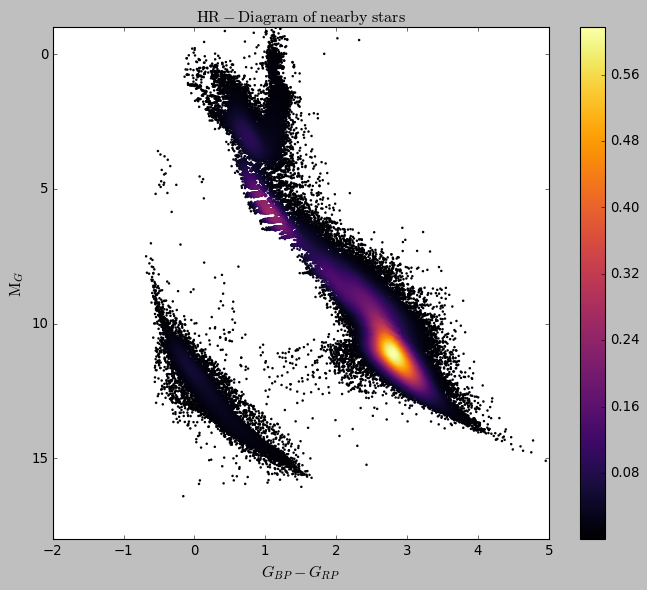

In [44]:
dsty = plot_HRD(sample,G_mean,BP_RP)

In [25]:
fast_kde(BP_RP,G_mean,sample=True)[2].shape

(200336,)

In [15]:
def calc_sigma_from_idxx(idx):

    """Function that applies equation 12 of DB98 for a set of stars from their tangential velocities and unit vectors.
    Returns the velocity dispersion tensor. Similar to calc_sigma2 of the Deproject code.
    
    This function is adapted to work together with scipy.stats.binned_statistic2d and takes the indices of the stars in 
    our sample that the velocity dispersion is to be computed for and returns the velocity dispersion for a given bin
    in G-BP_RP-space.
    """
    
    if len(idx)<2:
        return np.nan
    
    bin_stars = sample[idx]
    
    pbin,rhatbin = calc_p_rhat(bin_stars)
    
    sigma2 = calc_sigma2(pbin,rhatbin)
    
    sigma = np.sqrt(sigma2)
    
    return sigma[0]

def calc_sigma_from_idxy(idx):

    """Function that applies equation 12 of DB98 for a set of stars from their tangential velocities and unit vectors.
    Returns the velocity dispersion tensor. Similar to calc_sigma2 of the Deproject code.
    
    This function is adapted to work together with scipy.stats.binned_statistic2d and takes the indices of the stars in 
    our sample that the velocity dispersion is to be computed for and returns the velocity dispersion for a given bin
    in G-BP_RP-space.
    """
    
    if len(idx)<2:
        return np.nan
    
    bin_stars = sample[idx]
    
    pbin,rhatbin = calc_p_rhat(bin_stars)
    
    sigma2 = calc_sigma2(pbin,rhatbin)
    
    sigma = np.sqrt(sigma2)
    
    return sigma[1]

def calc_sigma_from_idxz(idx):

    """Function that applies equation 12 of DB98 for a set of stars from their tangential velocities and unit vectors.
    Returns the velocity dispersion tensor. Similar to calc_sigma2 of the Deproject code.
    
    This function is adapted to work together with scipy.stats.binned_statistic2d and takes the indices of the stars in 
    our sample that the velocity dispersion is to be computed for and returns the velocity dispersion for a given bin
    in G-BP_RP-space.
    """
    
    if len(idx)<2:
        return np.nan
    
    bin_stars = sample[idx]
    
    pbin,rhatbin = calc_p_rhat(bin_stars)
    
    sigma2 = calc_sigma2(pbin,rhatbin)
    
    sigma = np.sqrt(sigma2)
    
    return sigma[2]

The next function, $\texttt{plot_HRD_veldisp}$ takes the mean G magnitude, BP-RP and the parallax for a set of stars and provides an H-R diagram that also portrays the velocity dispersion $\sigma$ for a component of choice (x, y or z) for the stars. Said velocity dispersion is computed using the method of [(Dehnen & Binney, 1998)](https://ui.adsabs.harvard.edu/#abs/1998MNRAS.298..387D/abstract) in bins of size $0.3\times0.1$ mag.

In [33]:
def plot_HRD_veldisp(G_mean,BP_RP,parallax,sigma_comp,wd = False):
    
    if wd == True:
        
        xmin = -1
        xmax = 2
        ymin = 9
        ymax = 16
    else:
        xmin = -2
        xmax = 5
        ymin = -1
        ymax = 18
    
    Gvals = G_mean.value+5*np.log10(parallax.value)-10
    
    xbins = np.arange(BP_RP.value.min(),BP_RP.value.max()+0.1,0.1)
    ybins = np.arange(Gvals.min(),Gvals.max()+0.3,0.3)
    
    xc = (xbins[1:]+xbins[:-1])/2
    yc = (ybins[1:]+ybins[:-1])/2
    
    if sigma_comp == 'x':
        disp_func = calc_sigma_from_idxx
    elif sigma_comp == 'y':
        disp_func = calc_sigma_from_idxy
    elif sigma_comp == 'z':
        disp_func = calc_sigma_from_idxz
    else:
        raise ValueError('That\'s not a valid coordinate')
    
    idx = np.indices((Gvals.shape))
    
    bin_counts = bs2d(BP_RP,Gvals,None,'count',bins=[xbins,ybins])
    counts = bin_counts.statistic.astype(int)
    
    bin_stat_disp = bs2d(BP_RP,Gvals,idx,statistic = disp_func,bins=[xbins,ybins],expand_binnumbers=True)
    bin_disp = bin_stat_disp.statistic.reshape(counts.shape)
    
    bin_disp[counts<10] = np.nan
    
#     beta = 0.3
#     bin_disp_smooth = gaussian_filter(bin_disp, beta)    
    
    c_vals = bin_disp[bin_stat_disp.binnumber[0]-2,bin_stat_disp.binnumber[1]-2]
    
    sort_idx = c_vals.argsort()
    
    xvals, yvals, zvals = BP_RP[sort_idx],Gvals[sort_idx],c_vals[sort_idx]
    
    fig, ax = plt.subplots(figsize=(10,8))
    
    ax.set_title('$\mathrm{HR-Diagram\ with\ \sigma_' + '{}'.format(sigma_comp) + '\ for\ nearby\ stars}$',size='large')
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('$G_{BP}-G_{RP}$',size='large')
    ax.set_ylabel('$\mathrm{M}_G$',size='large')
    
    ax.invert_yaxis()
    
    extent = [xmin,xmax,ymin,ymax]

    im = ax.scatter(xvals,yvals,c=zvals,s=3,cmap=plt.cm.get_cmap('inferno'),edgecolor='',vmax=100)
    
#     im = ax.imshow(bin_disp.T,origin='lower',aspect='auto',extent=extent,cmap=plt.cm.get_cmap('inferno'),vmax=100)
#     im = ax.contourf(xc,yc,zvals.T,origin='lower',cmap=plt.cm.get_cmap('inferno'),vmax=300)
    cb = plt.colorbar(im)
    cb.set_label('$\sigma_'+'{}'.format(sigma_comp)+'\ [\mathrm{km}\ s^{-1}]$',size='large')
    
    plt.show()
    
    return

/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt
/home/jooehn/Downloads/ENTER/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


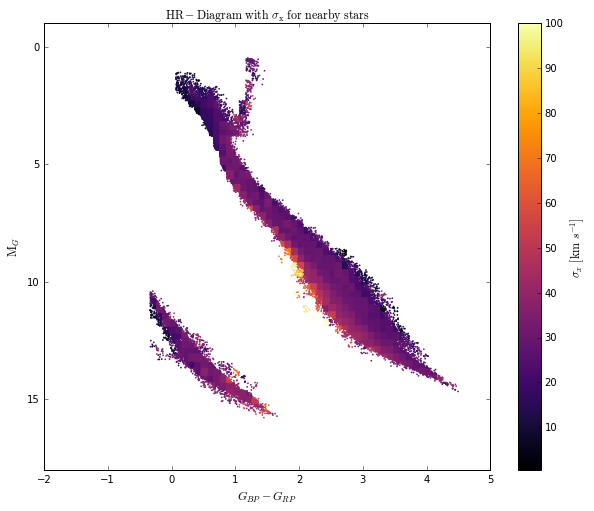

In [17]:
plot_HRD_veldisp(G_mean,BP_RP,parallax,'x')

In [130]:
indlist = np.concatenate([np.ravel(np.argwhere(~np.isnan(G_mean))),np.ravel(np.argwhere(~np.isnan(BP_RP)))]) 

notnan = np.unique(indlist)

parallax = sample[notnan].distance.to(u.mas,equivalencies=u.parallax())

G_meanp, BP_RPp = G_mean[notnan], BP_RP[notnan]